# Notebook to check z_b -N_grid figure

## Loading packages

In [1]:
import numpy as np
import MAS_library as MASL
import plotting_library as PL
from pylab import *
from matplotlib.colors import LogNorm
import matplotlib as plt
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
text_size=26
fig_size_x=24
fig_size_y=14
from collections import defaultdict

import seaborn as sns
Colors = sns.color_palette("colorblind", 50).as_hex()
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy import interpolate
%matplotlib widget
from scipy.interpolate import interp1d, UnivariateSpline
import scipy.integrate as integrate
import h5py
# from mayavi import mlab

In [2]:
def nested_dict(n, type):
    if n == 1:
        return defaultdict(type)
    else:
        return defaultdict(lambda: nested_dict(n-1, type))
    
data = nested_dict(5, list)
maximum = nested_dict(5, list)
variance = nested_dict(5, list)
avg = nested_dict(5, list)
sigma_R = nested_dict(5, list)

# Files loading

In [3]:
address = "/Users/farbod/Dropbox/Projects/Blowup-EFT-kessence_PRL_JCAP/Data/Runs_tes_z_b_vs_Ngrids_2Dec2021/"
name=["L300-Ngrid32-seed1", "L300-Ngrid64-seed1","L300-Ngrid128-seed1",
      "L300-Ngrid256-seed1","L300-Ngrid512-seed1"]
num=np.shape(name)[0]
for i in range(0,num):

    files= h5py.File(address+name[i]+'/lcdm_snap000_rhoN.h5', "r") 
#     hh= h5py.File('./CSCS_data_runs_Jan28/Blowup_sims/cs2_e7/solo_kess_eq/non_linear/cs2_e7_Ngrid_16_dtau_04/output////zeta_'+str(i)+'.h5', "r") 

    data[name[i]] = files['data']
    maximum[name[i]]=np.max( files['data']);
    variance[name[i]]=np.std( files['data']);
    avg[name[i]]=np.mean( files['data']);
    


# Variance 

## Variance theory (something wrong!)

In [4]:
import numpy as np
import mass_function_library as MFL

# read linear power spectrum
address = "/Users/farbod/Dropbox/Projects/Blowup-EFT-kessence_PRL_JCAP/Data/Runs_tes_z_b_vs_Ngrids_2Dec2021/class_powerspectra/"
k, Pk = np.loadtxt(address+'lcdm_settings_used00_z1_pk.dat', unpack=True)
k_nl, Pk_nl = np.loadtxt(address+'lcdm_settings_used00_z1_pk_nl.dat', unpack=True)

# compute the value of sigma_8
for R in np.arange(0.1,30,0.4):
    sigma_R['lin'][R] = MFL.sigma(k, Pk, R)
    sigma_R['nl'][R] = MFL.sigma(k_nl, Pk_nl, R)



/opt/anaconda3/lib/python3.7/site-packages/Pylians3-3.0-py3.7-macosx-10.9-x86_64.egg/mass_function_library.py:88: RuntimeWarning: invalid value encountered in sqrt
  'sigma', verbose=False)[0])


## Variance integral 

In [5]:
from scipy.integrate import quad

power_class = interpolate.interp1d(k,Pk);
power_class_nl = interpolate.interp1d(k_nl,Pk_nl);

def window(k,R):
    return (3.0 * ( np.sin(k*R) -k*R* np.cos(k*R))/(k*R)**3)
def integrand (k, R):
    return (power_class(k) * window(k,R)**2 * k**2/(2. * np.pi**2))
k_min = 0.01
k_max = 120
for R in np.arange(0.1,30,0.4):
    sigma_R['integral']['lin'][R] = quad(integrand, k_min, k_max, args=(R), epsabs=1.49e-08, epsrel=1.49e-08, limit=50, points=None, weight=None, wvar=None, wopts=None, maxp1=50, limlst=50)[0]
    sigma_R['integral']['nl'][R] = quad(integrand, k_min, k_max, args=(R), epsabs=1.49e-08, epsrel=1.49e-08, limit=50, points=None, weight=None, wvar=None, wopts=None, maxp1=50, limlst=50)[0]

    
    

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on

## Variance comparison theory vs N-body

In [6]:
# plt.figure(figsize=(20,16))

# for R in np.arange(0.1,30,3.2):
#     plt.scatter(R,sigma_R['lin'][R],marker="^",s=80,label="R="+str(R))
# for R in np.arange(0.1,20,3.2):
#     plt.scatter(R,(sigma_R['integral']['nl'][R]),marker="*",s=80,label="Integral, R="+str(R))
# for i in range(5):
#     plt.scatter(i,variance[name[i]],marker="s",s=80,label=name[i])
# plt.legend(fontsize=20)     
    
    
# # plt.tick_params(axis='x',          # changes apply to the x-axis
# #     which='both',      # both major and minor ticks are affected
# #     bottom=False,      # ticks along the bottom edge are off
# #     top=False,         # ticks along the top edge are off
# #     labelbottom=False,labelsize=20) 
# plt.tick_params(labelsize=20) 
# plt.yscale('log')
# plt.xscale('log')
# plt.ylabel("Variance",fontsize=24)
# plt.show()


# Maximum density vs Ngrid

## Fitting

In [22]:
data = np.zeros((5,2))
Ngrid = [32,64,128,258,512]
Ngrid=np.array(Ngrid)
for i in range(5):
    data[i,0] = Ngrid[i]; 
    data[i,1] = maximum[name[i]]

from scipy.optimize import curve_fit
def func(x, alpha, beta):
    return alpha *x  +beta
x = np.log(data[:,0])
y = np.log(data[:,1])
init_vals = [1, 1]  
best_vals, covar = curve_fit(func, x, y, p0=init_vals)

## Fig

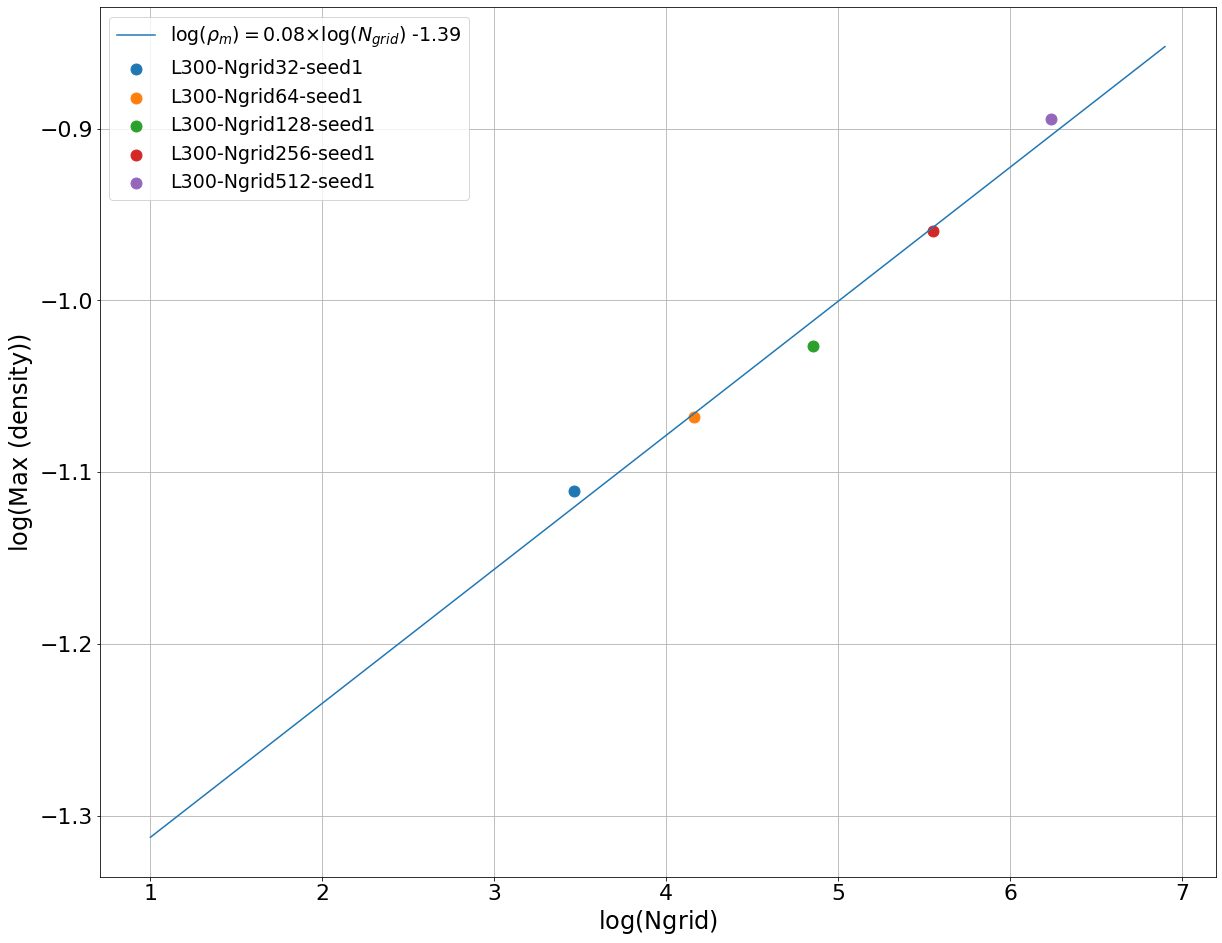

In [25]:
plt.figure(figsize=(20,16))

Ngrid = [32,64,128,258,512]
Ngrid=np.array(Ngrid)
for i in range(5):
    plt.scatter(np.log(Ngrid[i]),np.log(maximum[name[i]]),s=120,label=name[i])
    plt.legend(fontsize=20)     

data_range = np.arange(1,7,0.1)

## TESTS:

plt.plot (data_range,data_range * best_vals[0] + best_vals[1]  ,"-",markersize=20, label = r"$\log(\rho_m) = $"+ str(round(best_vals[0],2)) +r"$\times \log(N_{grid})$"+" "+str(round(best_vals[1],2)))

plt.legend(fontsize=19)
plt.tick_params(axis = 'both', which = 'major', labelsize = 22)
plt.tick_params(axis = 'both', which = 'minor', labelsize = 22)
plt.grid(True)

# plt.yscale('log')
# plt.xscale('log')

plt.ylabel("$\log$(Max (density))",fontsize=24)
plt.xlabel("$\log$(Ngrid)",fontsize=24)

plt.show()


# Max of density contrast as a function of N_grid for a fixed Boxsize

## Fitting

In [26]:
data = np.zeros((5,2))
Ngrid = [32,64,128,258,512]
Ngrid=np.array(Ngrid)
for i in range(5):
    data[i,0] = Ngrid[i]; 
    data[i,1] = (maximum[name[i]]-avg[name[i]])/avg[name[i]]

from scipy.optimize import curve_fit
def func(x, alpha, beta):
    return alpha *x  +beta
x = np.log(data[:,0])
y = np.log(data[:,1])
init_vals = [1, 1]  
best_vals, covar = curve_fit(func, x, y, p0=init_vals)

## Fig

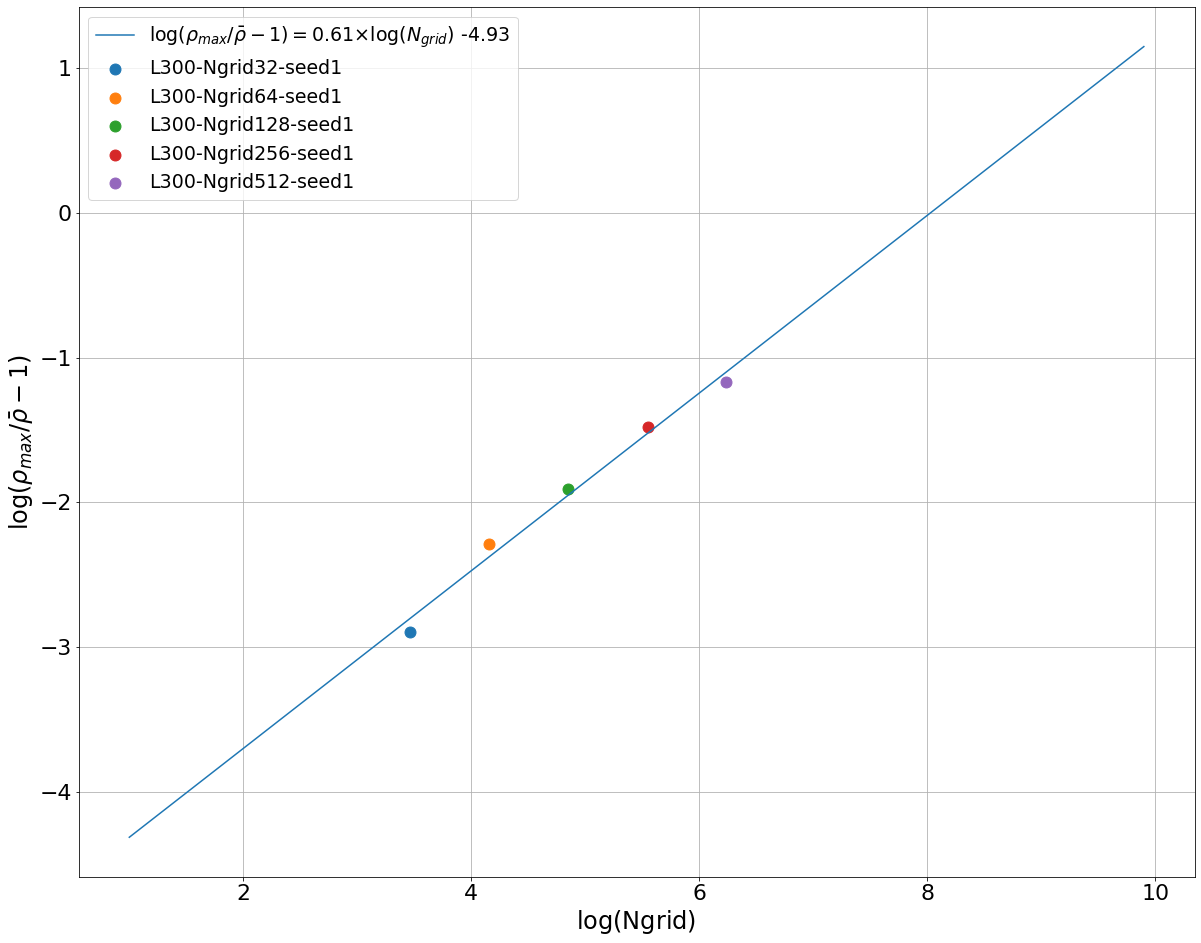

In [29]:
plt.figure(figsize=(20,16))

Ngrid = [32,64,128,258,512]
Ngrid=np.array(Ngrid)
for i in range(5):
    plt.scatter(np.log(Ngrid[i]),np.log((maximum[name[i]]-avg[name[i]])/avg[name[i]]),s=120,label=name[i])
    plt.legend(fontsize=20)     

data_range = np.arange(1,10,0.1)

## TESTS:

plt.plot (data_range,data_range * best_vals[0] + best_vals[1]  ,"-",markersize=20, label = r"$\log(\rho_{max}/\bar{\rho} -1) = $"+ str(round(best_vals[0],2)) +r"$\times \log(N_{grid})$"+" "+str(round(best_vals[1],2)))

plt.legend(fontsize=19)
plt.tick_params(axis = 'both', which = 'major', labelsize = 22)
plt.tick_params(axis = 'both', which = 'minor', labelsize = 22)
plt.grid(True)

# plt.yscale('log')
# plt.xscale('log')

plt.ylabel(r"$\log(\rho_{max}/\bar{\rho} -1$)",fontsize=24)
plt.xlabel("$\log$(Ngrid)",fontsize=24)

plt.show()


# Dependence on the seed number

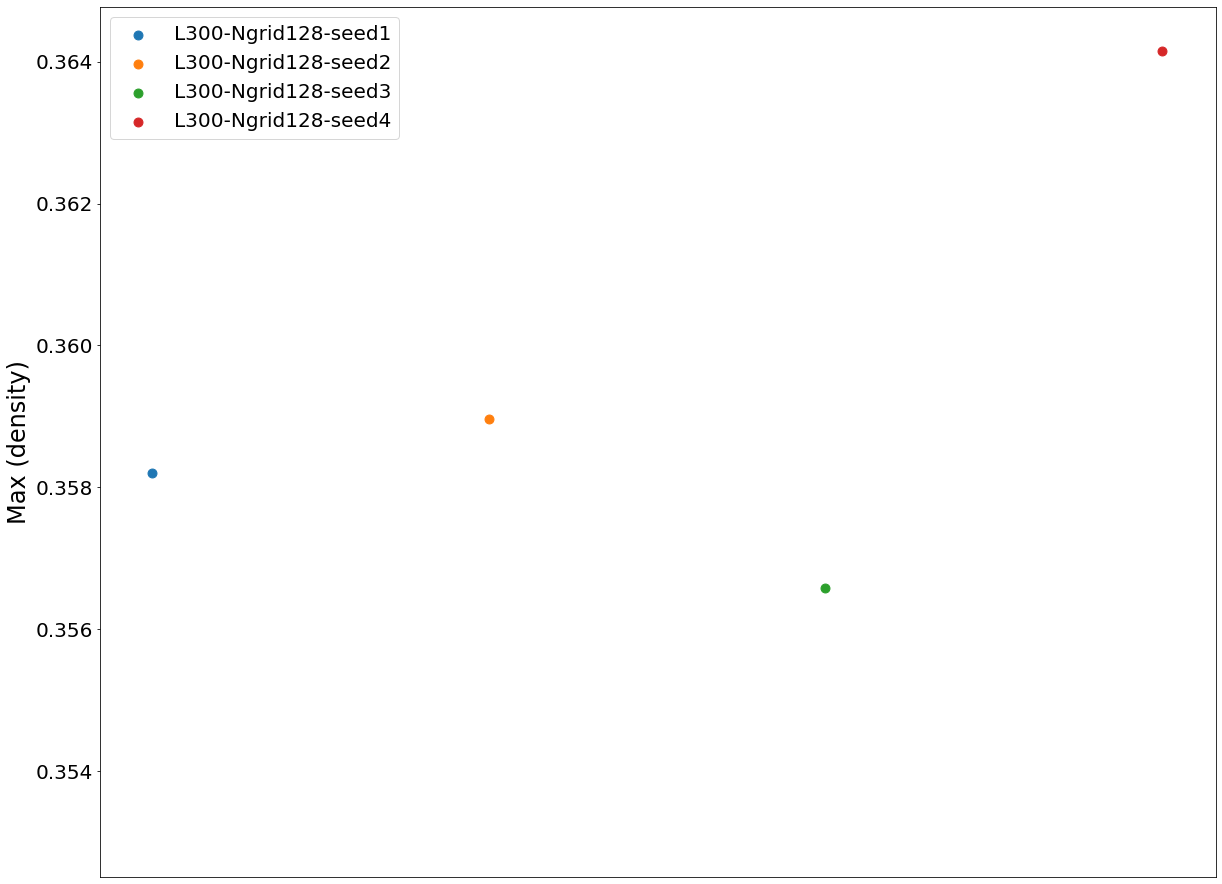

In [16]:
plt.figure(figsize=(20,16))

x = np.arange(0,num,1)
for i in [5,6,7,8]:
    plt.scatter(i,maximum[name[i]],s=80,label=name[i])
    plt.legend(fontsize=20)     
    
plt.tick_params(axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,labelsize=20) 
plt.tick_params(labelsize=20) 
plt.ylabel("Max (density)",fontsize=24)
plt.show()


# Max density as a functin of resolution for fixed box

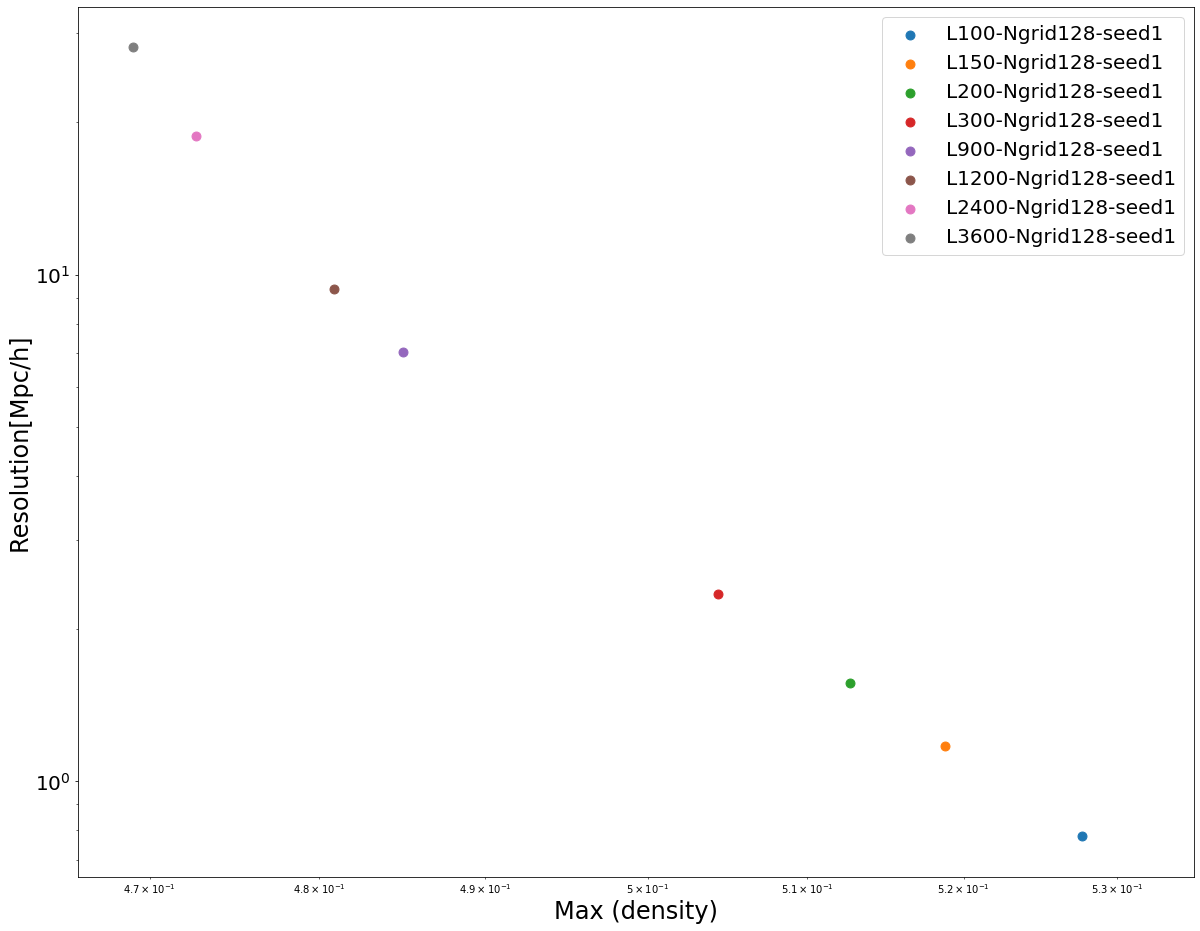

In [112]:
plt.figure(figsize=(20,16))

L = [100,150,200,300,900,1200,2400,3600]
L=np.array(L)/128;
x = np.arange(1,30,0.2)
l=0
for i in [1,2,3,5,10,11,12,13]:
    plt.scatter(maximum[name[i]]**(2/3), L[l],s=80,label=name[i])
#     plt.scatter(x,10/x**1/3,s=80,marker="*")
    plt.legend(fontsize=20)     
    l=l+1
    
# plt.tick_params(axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False,labelsize=20) 
plt.tick_params(labelsize=20) 

plt.xlabel("Max (density)",fontsize=24)
plt.ylabel("Resolution[Mpc/h]",fontsize=24)
plt.yscale('log')
plt.xscale('log')

plt.show()


# Max density for a fixed box as a function of N_grid

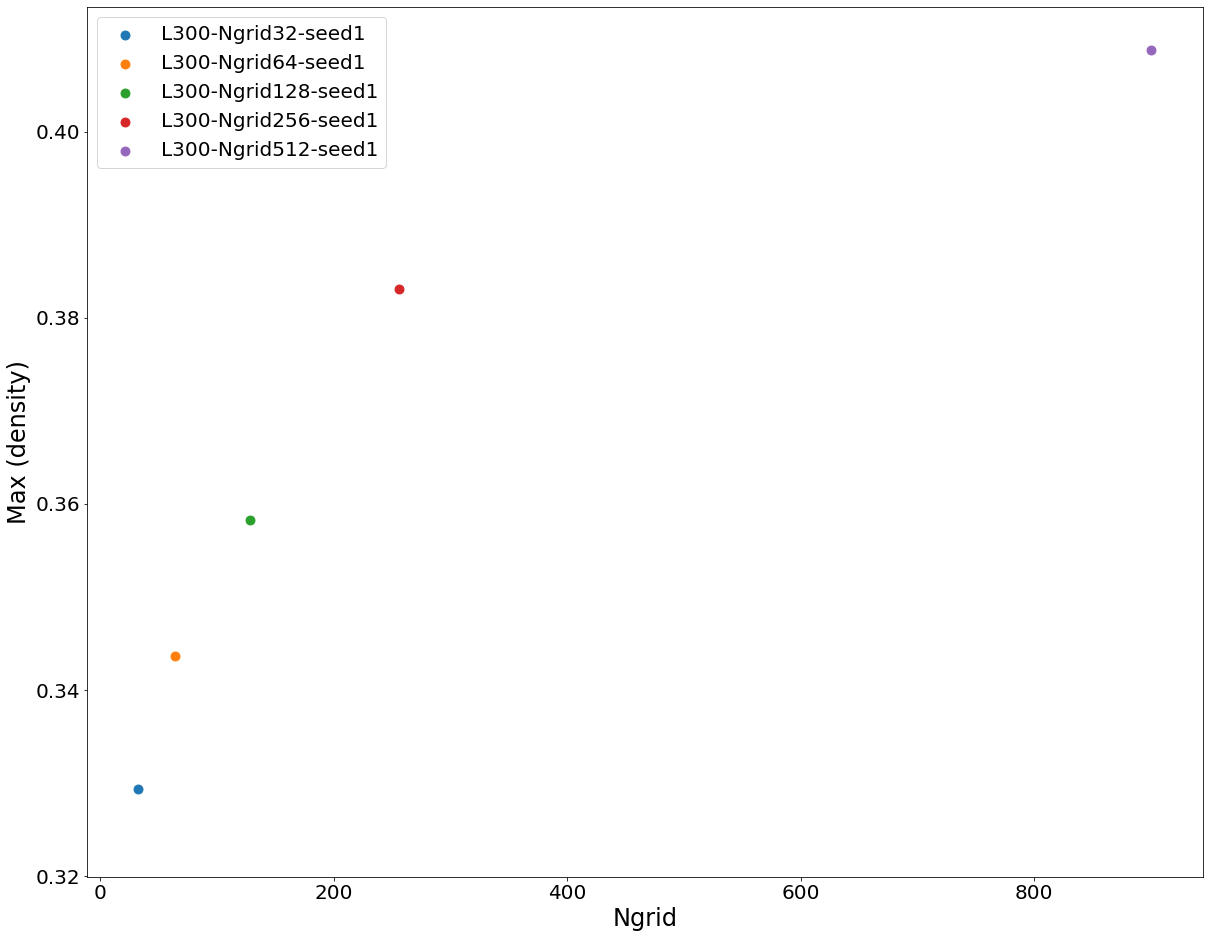

In [79]:
plt.figure(figsize=(20,16))
# name=["L50-Ngrid128-seed1","L100-Ngrid128-seed1","L150-Ngrid128-seed1",
#       "L200-Ngrid128-seed1","L300-Ngrid64-seed1","L300-Ngrid128-seed1",
#       "L300-Ngrid128-seed2","L300-Ngrid128-seed3","L300-Ngrid128-seed4",
#       "L600-Ngrid128-seed1","L900-Ngrid128-seed1","L1200-Ngrid128-seed1",
#       "L2400-Ngrid128-seed1","L3600-Ngrid128-seed1","L300-Ngrid32-seed1",
#       "L300-Ngrid256-seed1","L300-Ngrid512-seed1","L150-Ngrid32-seed1","L1200-Ngrid256-seed1"]
Ngrid = [32,64,128,256,900,512]
x = np.arange(0,num,1)
l=0
for i in [14,4,5,15,16]:
    plt.scatter(Ngrid[l],maximum[name[i]],s=80,label=name[i])
    plt.legend(fontsize=20)     
    l=l+1
    
# plt.tick_params(axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False,labelsize=20) 
plt.tick_params(labelsize=20) 
plt.ylabel("Max (density)",fontsize=24)
plt.xlabel("Ngrid",fontsize=24)

plt.show()


## Tests:

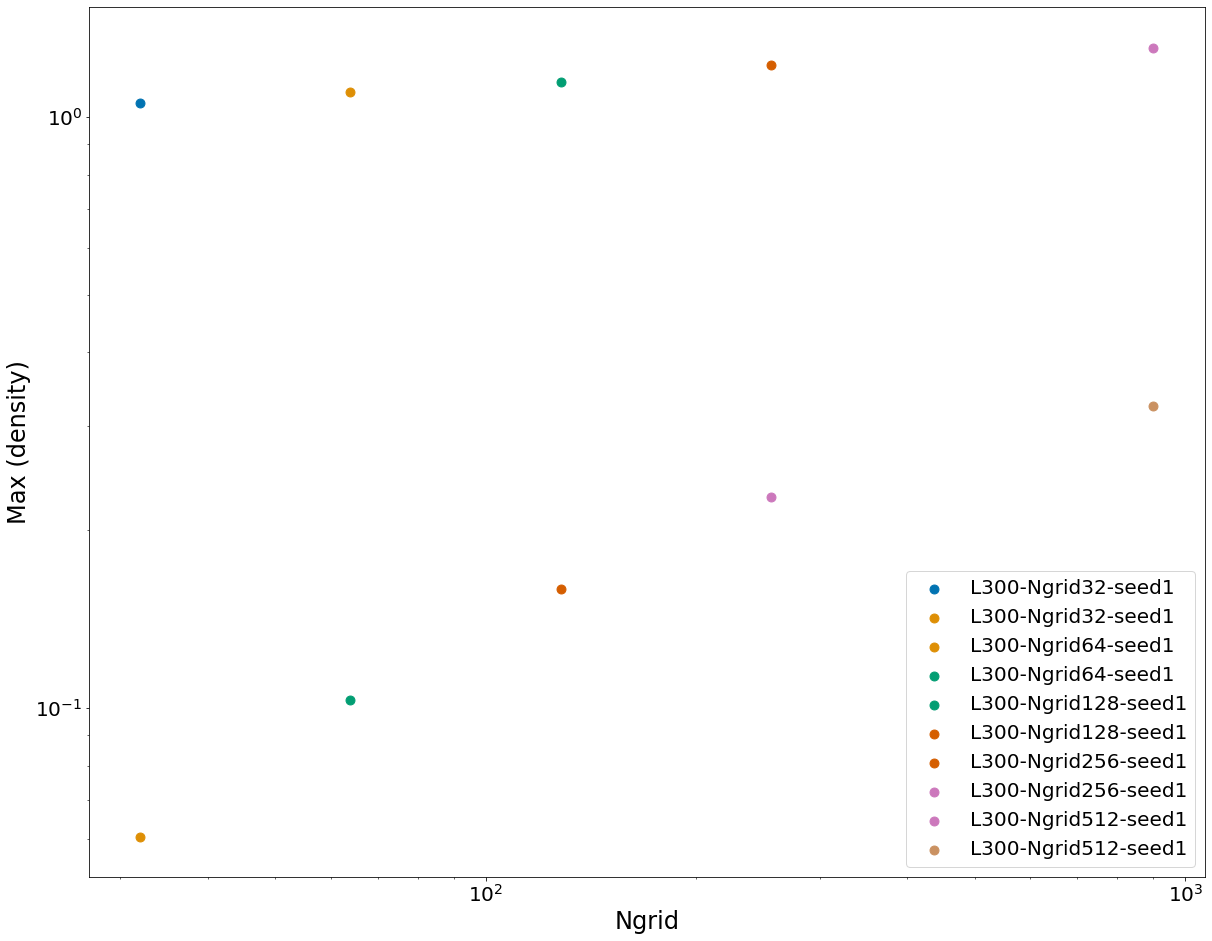

In [107]:
plt.figure(figsize=(20,16))
# name=["L50-Ngrid128-seed1","L100-Ngrid128-seed1","L150-Ngrid128-seed1",
#       "L200-Ngrid128-seed1","L300-Ngrid64-seed1","L300-Ngrid128-seed1",
#       "L300-Ngrid128-seed2","L300-Ngrid128-seed3","L300-Ngrid128-seed4",
#       "L600-Ngrid128-seed1","L900-Ngrid128-seed1","L1200-Ngrid128-seed1",
#       "L2400-Ngrid128-seed1","L3600-Ngrid128-seed1","L300-Ngrid32-seed1",
#       "L300-Ngrid256-seed1","L300-Ngrid512-seed1","L150-Ngrid32-seed1","L1200-Ngrid256-seed1"]
Ngrid = [32,64,128,256,900,512]
x = np.arange(0,num,1)
l=0
for i in [14,4,5,15,16]:
    plt.scatter(Ngrid[l],maximum[name[i]]/avg[name[i]],s=80,color=Colors[l], label=name[i])
    plt.scatter(Ngrid[l],(variance[name[i]]/avg[name[i]])*np.sqrt(2.0*np.log(Ngrid[l]**3)),color=Colors[l+1],s=80,label=name[i])
    
    plt.legend(fontsize=20)     
    l=l+1
    
plt.tick_params(labelsize=20) 
plt.ylabel("Max (density)",fontsize=24)
plt.xlabel("Ngrid",fontsize=24)
plt.yscale('log')
plt.xscale('log')
plt.show()


# Max density vs Gumbel distribution prediction (Max ~ sigma_R * sqrt(2 Ln N_grid^3))

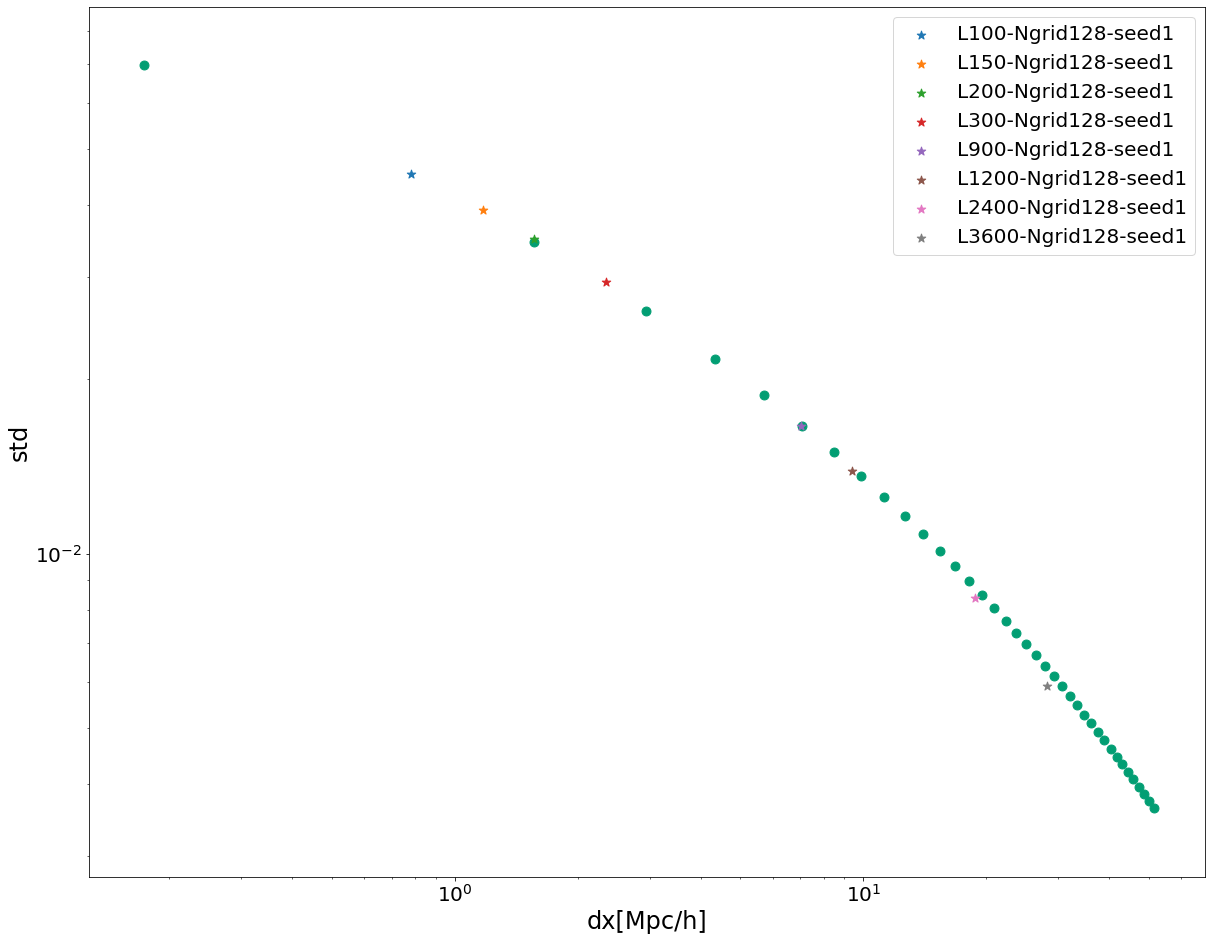

In [101]:
plt.figure(figsize=(20,16))

L = [100,150,200,300,900,1200,2400,3600]
x = np.arange(0,num,1)
l=0

for R in np.arange(0.1,30,0.8):
#     plt.scatter(R,sigma_R['lin'][R],color=Colors[l],marker="*",s=80)
#     plt.scatter(R,(sigma_R['nl'][R]),color=Colors[l+1],marker="s",s=80)
    plt.scatter(R*np.sqrt(3), np.sqrt(sigma_R['integral']['lin'][R]),color=Colors[l+2],marker="o",s=80)
#     plt.scatter(R, sigma_R['integral']['nl'][R],color=Colors[l+3],marker="^",s=80)

for i in [1,2,3,5,10,11,12,13]:
#     plt.scatter(L[l]/128,maximum[name[i]]-avg[name[i]],s=80,label=name[i])
    plt.scatter(L[l]/128, variance[name[i]]/avg[name[i]],marker="*",s=80,label=name[i])
# variance[name[i]]
    plt.legend(fontsize=20)     
    l=l+1
    
# plt.tick_params(axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False,labelsize=20) 
plt.tick_params(labelsize=20)
plt.ylabel("std",fontsize=24)
plt.xlabel("dx[Mpc/h]",fontsize=24)
plt.yscale('log')
plt.xscale('log')

plt.show()


In [ ]:
plt.figure(figsize=(20,16))

L = [100,150,200,300,900,1200,2400,3600]
x = np.arange(0,num,1)
l=0

for R in np.arange(0.1,30,0.8):
#     plt.scatter(R,sigma_R['lin'][R],color=Colors[l],marker="*",s=80)
#     plt.scatter(R,(sigma_R['nl'][R]),color=Colors[l+1],marker="s",s=80)
    plt.scatter(R*np.sqrt(3), np.sqrt(sigma_R['integral']['lin'][R]),color=Colors[l+2],marker="o",s=80)
#     plt.scatter(R, sigma_R['integral']['nl'][R],color=Colors[l+3],marker="^",s=80)

for i in [1,2,3,5,10,11,12,13]:
#     plt.scatter(L[l]/128,maximum[name[i]]-avg[name[i]],s=80,label=name[i])
    plt.scatter(L[l]/128, variance[name[i]]/avg[name[i]],marker="*",s=80,label=name[i])
# variance[name[i]]
    plt.legend(fontsize=20)     
    l=l+1
    
# plt.tick_params(axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False,labelsize=20) 
plt.tick_params(labelsize=20)
plt.ylabel("std",fontsize=24)
plt.xlabel("dx[Mpc/h]",fontsize=24)
plt.yscale('log')
plt.xscale('log')

plt.show()


# To get sense of dependence on sqrt(2 log(N_grid^3))

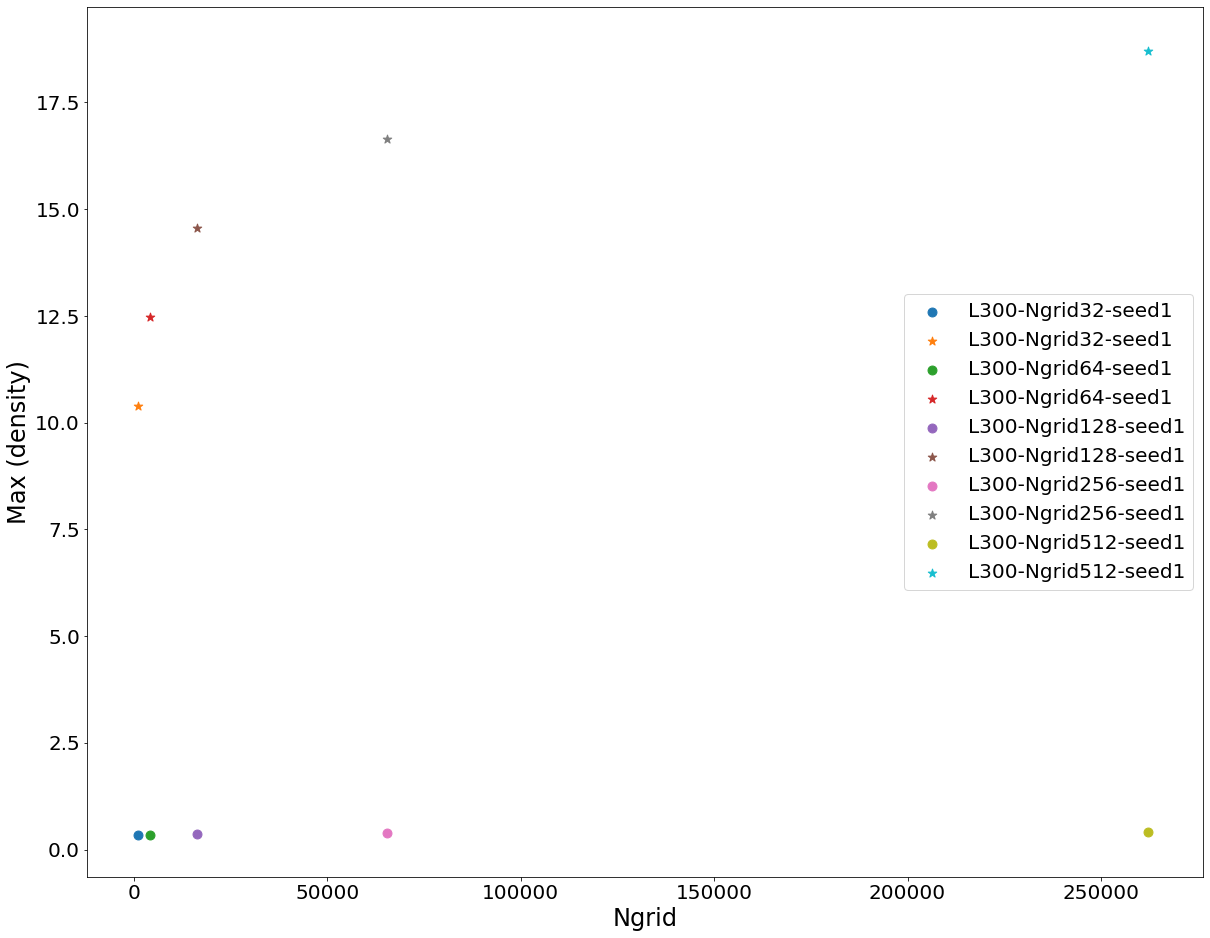

In [25]:
plt.figure(figsize=(20,16))

Ngrid = [32,64,128,256,512]
x = np.arange(0,num,1)
l=0
for i in [14,4,5,15,16]:
    plt.scatter(Ngrid[l]**2,maximum[name[i]],s=80,label=name[i])
    plt.scatter(Ngrid[l]**2,np.log(Ngrid[l]**3),marker="*",s=80,label=name[i])

    plt.legend(fontsize=20)     
    l=l+1
    
# plt.tick_params(axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False,labelsize=20) 
plt.tick_params(labelsize=20) 
plt.ylabel("Max (density)",fontsize=24)
plt.xlabel("Ngrid",fontsize=24)

plt.show()
